# Laboratorium 3 - triangulacja wielokątów monotonicznych

## Autor: Tomasz Boroń

###### Narzędzie graficzne

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

###### Interfejsy

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()        

## Funkcje pomocnicze

###### Dokładność 0

In [3]:
eps=10**(-10)

###### Możliwa klasyfikacja punktów

In [4]:
starting=[]
ending=[]
connecting=[]
dividing=[]
regular=[]

###### Wyznacznik 3x3

In [5]:
def det(a,b,c):
    return a[0]*b[1]+a[1]*c[0]+b[0]*c[1]-c[0]*b[1]-c[1]*a[0]-b[0]*a[1]

###### Długość wektora

In [6]:
from math import sqrt

def vec_len(a,b):
    return sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)

###### Sprawdzanie, czy kąt wewnętrzny przy wierzchołku a jest mniejszy od PI

In [7]:
def angle_smaller_than_pi(a,b,c):
    if det(a,b,c) > eps:
        return True
    return False

###### Zamiana figury na listę wierzchołków

In [8]:
def convert_figure_to_points_list(figure):
    return [i[0] for i in figure]

#print(convert_figure_to_points_list(figure))

## Algorytmy

###### Klasyfikacja wierzchołków

In [9]:
%matplotlib notebook

def points_classify(figure):
    starting.clear()
    ending.clear()
    connecting.clear()
    dividing.clear()
    regular.clear()
    points=convert_figure_to_points_list(figure)   # lista wierzchołków figury
    #print(points)
    n=len(points)
    for i in range(n):
        if points[i][1]<points[(i+1)%n][1] and points[i][1]<points[(i-1)%n][1]: #obaj sąsiedzi powyżej
            if angle_smaller_than_pi(points[(i-1)%n],points[i],points[(i+1)%n]):
                ending.append(points[i])
            else:
                connecting.append(points[i])
        elif points[i][1]>points[(i+1)%n][1] and points[i][1]>points[(i-1)%n][1]: #obaj sąsiedzi poniżej
            if angle_smaller_than_pi(points[(i-1)%n],points[i],points[(i+1)%n]):
                starting.append(points[i])
            else:
                dividing.append(points[i])
        else:
            regular.append(points[i])

###### Badanie y-monotoniczności przy użyciu wcześniejszej klasyfikacji wierzchołków

In [10]:
def y_monotonicity(figure):
    points_classify(figure)
    if len(connecting)==0 and len(dividing)==0: return True
    return False

###### Triangulacja wielokąta monotonicznego

In [60]:
scenes=[]

def triangulate(figure):
    scenes.clear()
    triangles=[]
    if not y_monotonicity(figure): return triangles
    points=convert_figure_to_points_list(figure)   # lista wierzchołków figury
    topindex=0 # indeks najwyższego punktu
    top=points[0] # najwyższy punkt
    bottom=points[0] # najniższy punkt
    for i in range(1,len(points)): # poszukiwanie top i bottom
        if points[i][1]>top[1]:
            topindex=i
            top=points[i]
        elif points[i][1]<bottom[1]:
            bottom=points[i]
    scenes.append(Scene([PointsCollection(points)],
                        [LinesCollection(figure)]))
    n=len(figure)
    leftchain=[]  # podział na łańcuchy, założenie że bottom należy do obu
    rightchain=[]
    index=(topindex+1)%n
    while figure[index][0]!=bottom:
        leftchain.append(figure[index][0])
        index=(index+1)%n
    leftchain.append(bottom)
    index=(topindex-1)%n
    while figure[index][0]!=bottom:
        rightchain.append(figure[index][0])
        index=(index-1)%n
    rightchain.append(bottom)
    scenes.append(Scene([PointsCollection(leftchain[0:len(leftchain)],color="lime"), # scena pokazująca łańcuchy
                         PointsCollection(rightchain[0:len(rightchain)],color="red")
                       ],[LinesCollection(figure)]))
    pointsQueue=[] # punkty w kolejności brania
    ileft=0
    iright=0
    while ileft<len(leftchain) and iright<len(rightchain):
        if leftchain[ileft][1]>rightchain[iright][1]:
            pointsQueue.append((leftchain[ileft],-1)) # -1 - lewo, 1 - prawo, aby móc złożyć warunek na trójkąt wewnątrz w jedno, niezależnie od łańcucha
            ileft+=1
        else:
            pointsQueue.append((rightchain[iright],1))
            iright+=1
    stack=[] # jednak lista ze wskazaniem na pierwszy i ostatni element zamiast "typowego stosu"; w innym języku programowania byłby to stos z wskazaniem na szczyt i spód
    stack.append(top)
    stack.append(pointsQueue[0][0])
    lines=[]
    for i in range (1,len(pointsQueue)):
        if pointsQueue[i][1]!=pointsQueue[i-1][1]:  # zmiana łańcucha
            for j in range(len(stack)-1):
                triangles.append((pointsQueue[i][0],stack[0],stack[1]))
                lines.append([pointsQueue[i][0],stack.pop(0)])
            lines.append([pointsQueue[i][0],stack[0]])
            stack.append(pointsQueue[i][0])
        else:                                       # nie zmieniamy łańcucha
            reverse_stack=[] # struktura, która stworzy nam odwrotny stos (listę) niż będziemy potrzebować
            while len(stack)>1:
                if pointsQueue[i][1]*det(pointsQueue[i][0],stack[-1],stack[-2])>eps: # warunek na trójkąt wewnątrz
                    triangles.append((pointsQueue[i][0],stack[-1],stack[-2]))
                    lines.append([pointsQueue[i][0],stack[-2]])
                else:
                    reverse_stack.append(stack[-1]) # badany wierzchołek zostaje, a konstrukcja ta pozwoli mu utrzymać odpowiednie
                                                    # miejsce na stosie
                stack.pop(-1) # zmniejszanie stosu
            reverse_stack.append(stack[0]) # cztery linijki konfiguracji właściwego stosu
            reverse_stack.reverse()
            stack=reverse_stack
            stack.append(pointsQueue[i][0])
        scenes.append(Scene([PointsCollection(points)],
                            [LinesCollection(lines[0:len(lines)],color="red"),LinesCollection(figure)]))
    return triangles

###### Miejsce do rysowania wielokąta

<IPython.core.display.Javascript object>


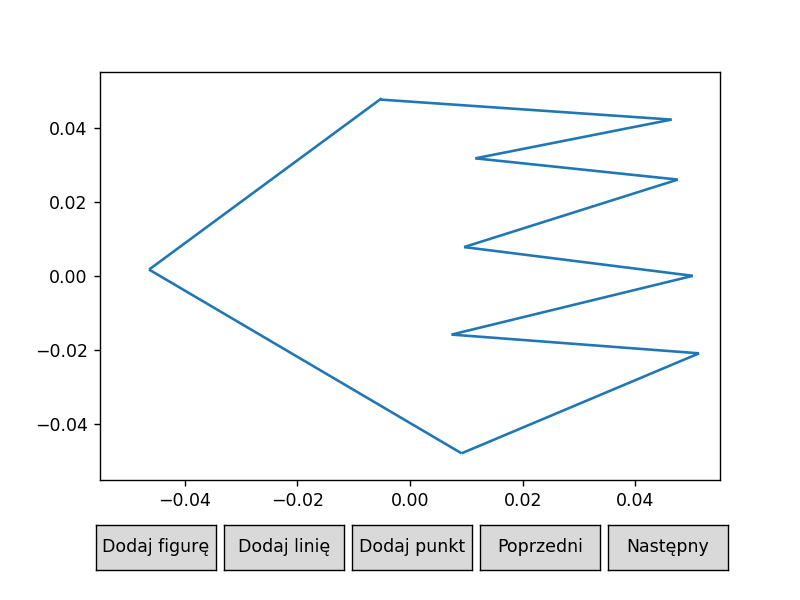

In [75]:
plot1=Plot(points=[PointsCollection([(0, 0)], color='white')])
plot1.draw()

###### Zapis linii w tablicy i odtworzenie wielokąta dodatkowo delikatna korekta aby mieć domknięty wielokąt

<IPython.core.display.Javascript object>


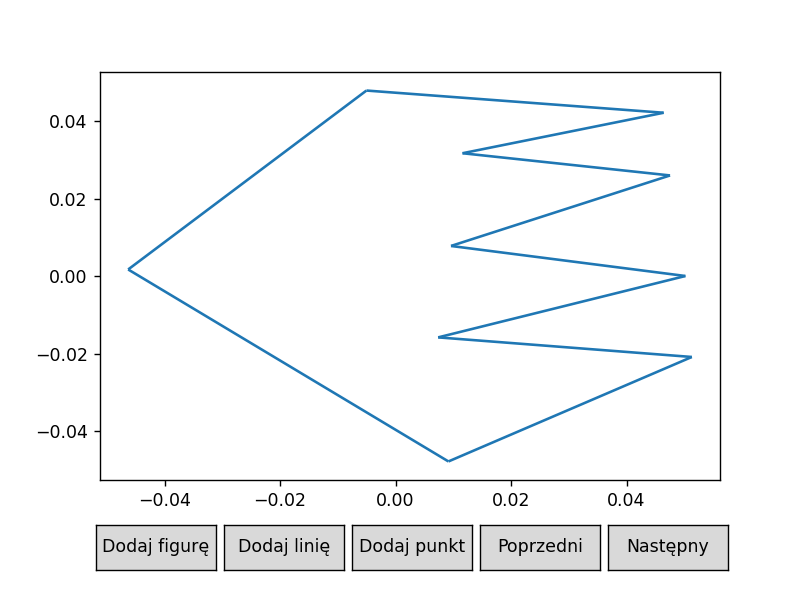

In [76]:
figure=plot1.get_added_figure()[0].lines
#print(figure)
#print(figure[len(figure)-1])
# delikatna poprawka figury jeśli się nie trafiło idealnie spowrotem w pierwszy wierzchołek
if not figure[0][0]==figure[len(figure)-1][1]:
    begin=figure[len(figure)-1][0]
    figure.pop(-1)
    figure.append([(begin),(figure[0][0])])
#print(figure[len(figure)-1])
plot2 = Plot(lines=[LinesCollection(figure)])
plot2.draw()

###### Wizualizacja klasyfikacji punktów

<IPython.core.display.Javascript object>


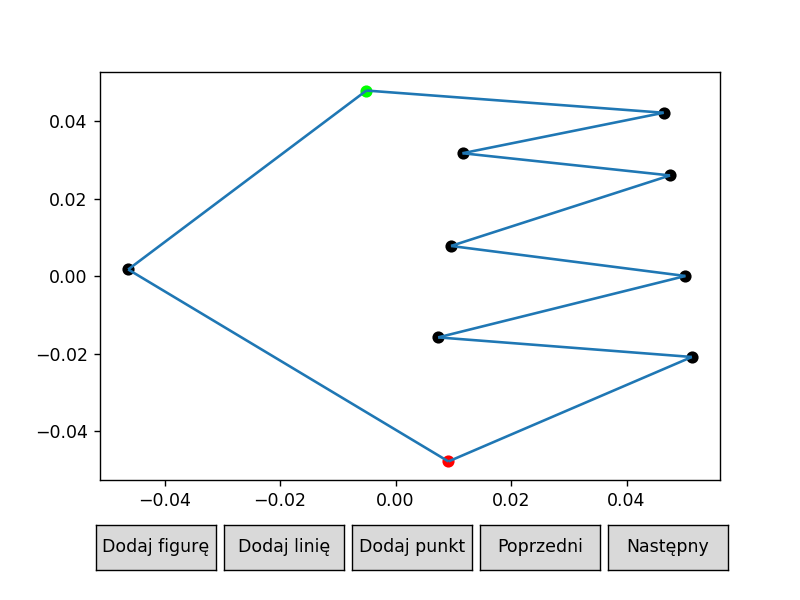

In [77]:
points_classify(figure)
plot3 = Plot(points=[PointsCollection(starting,color = "lime"),
                 PointsCollection(ending,color = "red"),         
                 PointsCollection(connecting,color = "blue"),
                 PointsCollection(dividing,color = "lightblue"),
                 PointsCollection(regular,color = "black")],
        lines=[LinesCollection(figure)])
plot3.draw()

###### Wizualizacja triangulacji

<IPython.core.display.Javascript object>


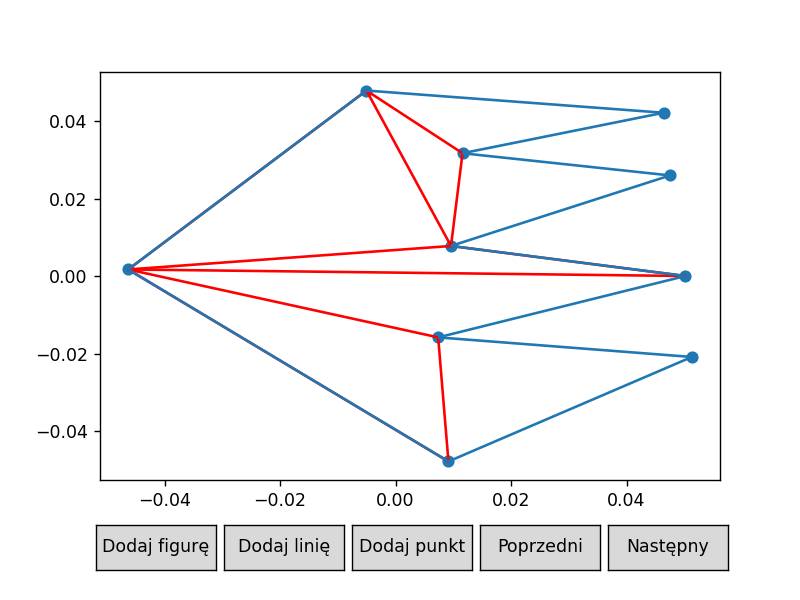

In [78]:
#print(triangulate(figure)) odkomentować aby zobaczyć wynik triangulacji w postaci listy krotek
triangulate(figure)
plotTriangulation = Plot(scenes=scenes)
plotTriangulation.draw()